In [1]:
# from __future__ import division, print_function, absolute_import
%matplotlib inline
import numpy as np

from phidl import Device, Layer, LayerSet, make_device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu

# import customed geolib
import mine as mn
import matplotlib.pyplot as plt

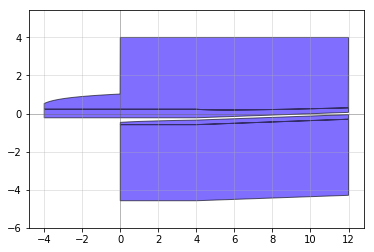

'seg.gds'

In [10]:
wr1 = .45
wr2 = .24
wslot = .12
l0 = 4
l1 = 4
l2 = 8
# z = 


A1 = .500
A2 = .200
A3=.200 

B1 = 2.25  
B2 = 0.745
B3 = 1.28
C1 = .525
    
w1 = .450
w2 = .12
wslab = 4

pA = [l1, -.5*wr1]
pB = [l1+l2, .5*wslot]
pC = [l1+l2, .5*wslot+wr2]
pD = [l1, .5*wr1]

slope = (pB[1]-pA[1])/(pB[0]-pA[0])

def logW(l,w,A,B,l0):
    return w - A*np.log10(B*(l-l0)+1)





z2 = np.arange(0,l1,0.01)
xpts2 = [0] + list(z2) + [l1,l1+l2,l1+l2,l1,0]
x2 = [-wr1*.5-wr2-wslot + logW(z, w2, -A2, B2, 0) for z in z2]
ypts2 = [-wr1*.5-wr2-wslot+w2] + x2 + [-wslot-wr1*.5,-wslot*.5,-wslot*.5-wr2,-wslot-wr1*.5-wr2,-wslot-wr1*.5-wr2]

z3 = np.arange(l1,l2+l1,0.01)
xpts3 = [-l0,l1] + list(z3) + [l1+l2,l1+l2,l1,-l0]
x3 = [slope*(z-l1)-.5*wr1+logW(z, wr1, A3, B3, l1) for z in z3]
ypts3 = [wr1*.5,wr1*.5] + x3 + [wslot*.5+wr2,wslot*.5,-wr1*.5,-wr1*.5]


z1 = np.arange(-l0,0,0.01)
xpts1 = [-l0] + list(z1) + [0,l1+l2]+ list(z3)[::-1] +[l1]
x1 = [logW(z, C1, -A1, B1, -l0) for z in z1]
ypts1 = [w1*.5] + x1 + [wslab,wslab]+ x3[::-1] +[w1*.5]


D = Device('slot_convertor')
D.add_polygon(points=(xpts3,ypts3),layer=1)
D.add_polygon(points=(xpts2,ypts2),layer=1)
D.add_polygon(points=(xpts1,ypts1),layer=1)
D.add_polygon(points=([0,l1,l1+l2,l1+l2,l1,0], 
                      [-wr1*.5-wr2-wslot,-wr1*.5-wr2-wslot,-wr2-wslot*.5,-wr2-wslot*.5-wslab,
                      -wr1*.5-wr2-wslot-wslab,-wr1*.5-wr2-wslot-wslab]),layer=1)
qp(D)
D.write_gds('seg.gds')


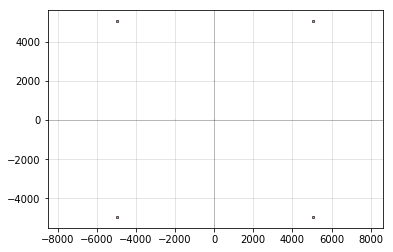

'tric_simple.gds'

In [11]:
D = Device('tric')

distance = 2e3
radius = 2.5
D << pg.circle(radius=radius)
D << pg.circle(radius=radius).movex(-distance)
D << pg.circle(radius=radius).movey(distance)

pad = 5e3
D << pg.rectangle((100,100), layer=2).move((pad,pad))
D << pg.rectangle((100,100), layer=2).move((pad,-pad))
D << pg.rectangle((100,100), layer=2).move((-pad,pad))
D << pg.rectangle((100,100), layer=2).move((-pad,-pad))
qp(D)
D.flatten().write_gds('tric_simple.gds')

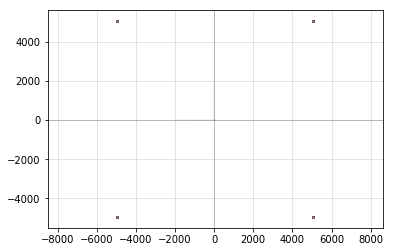

'tric_array_PD100.0_NUM20.gds'

In [13]:
D = Device('tric')

num = 20
pd = 1e2
radius = 2.5
D << pg.circle(radius=radius)
for i in range(num):
    D << pg.circle(radius=radius).movex(-pd*i)
for i in range(num):
    D << pg.circle(radius=radius).movey(pd*i)
pad = 5e3

D << pg.rectangle((100,100), layer=2).move((pad,pad))
D << pg.rectangle((100,100), layer=2).move((pad,-pad))
D << pg.rectangle((100,100), layer=2).move((-pad,pad))
D << pg.rectangle((100,100), layer=2).move((-pad,-pad))

qp(D)
D.flatten().write_gds(f'tric_array_PD{pd}_NUM{num}.gds')

In [3]:
D = Device('CJC')
LB_CEL = Device('LB_CEL')

def asymMRR(width_rg=1, width_bus=1, radius=30, gap=0.1,lenL=10,lenR=10):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg, angle_resolution=.1)
    BUS = D << mn.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus).movex(-radius-(width_rg)/2-lenL)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D
w = 1.5 # width of
wBus = 1.5
wRg = w
# wTp = 0.2

devLen = 10000
rRg = 100

HD = 4*rRg
VD = rRg*.8
num = 8 # num of MRR

gapPeriod = .05
offset = devLen/2 - num*HD/2
# margin = 100

for i in range(num):
    gap = gapPeriod*i+0.1
    MRR = D << asymMRR(width_bus=wBus,
                       width_rg=wRg,radius=rRg, 
                       gap=gap,
                       lenL=i*HD+i*rRg,
                       lenR=0).move((offset+HD*i,-VD*i))
    LB_CEL << pg.text(text='GAP%d' % (1e3*gap), layer=2, justify='right').move((offset+HD*i,-VD*i))
    TPCL = D << pg.connector((0,rRg-VD*i),width=wBus)
    TPCR = D << pg.connector((devLen,rRg-VD*i),width=wBus)
#     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
    RT1 = D << pr.route_manhattan(port1=TPCL.ports[1],port2=MRR.ports[2],
                                  bendType='circular',radius=rRg)
    RT2 = D << pr.route_manhattan(port1=TPCR.ports[2],port2=MRR.ports[1],
                                  bendType='circular',radius=rRg)

mark = [pg.rectangle((100,100), layer=2).move((300*i,-(num)*VD)) for i in range(5)]
mark2 = [pg.rectangle((100,100), layer=2).move((devLen-300*i-100,-(num)*VD)) for i in range(5)]

bar =  mn.waveguide(length=devLen,width=wBus).move((0,-(num+1)*VD))
for i in range(3):
    D << pg.copy(bar).movey(-i*VD)
    
D_out = pg.outline(D, distance=10, layer=1)

for i in (D, D_out):
    i << LB_CEL
    i << tuple(mark)
    i << tuple(mark2)

D.rotate(90)
D_out.flatten().write_gds('190807-nanofab-mrr-nega.gds')
D.flatten().write_gds('190807-nanofab-mrr-posi.gds')

'190807-nanofab-mrr-posi.gds'

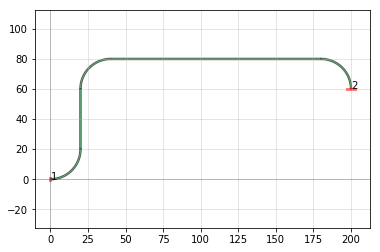

'view.gds'

In [139]:
D = Device('bus')

# wg1 = D << pg.connector(width=0.5)
# arc1 = D << pg.turn(wg1.ports[2],angle=10,radius=100,angle_resolution=1)
# arc2 = D << pg.turn(arc1.ports[2],angle=-20,radius=100,angle_resolution=1)
# arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)
# wg2 = D << waveguide(0.5,20)
c1 = pg.connector(midpoint=(0,0),width=1,orientation=0)
c2 = pg.connector(midpoint=(200,60),width=5,orientation=270)
D << pr.route_manhattan(port1=c1.ports[1],port2=c2.ports[2], radius=20)
qp(D)

D.flatten().write_gds('view.gds')

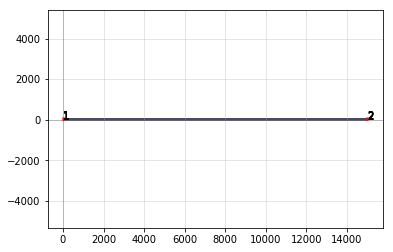

'templates/trench.gds'

In [78]:
# create trenches to test etching rate
D = Device('trench')

w_l = [0.2,0.3,0.4,0.6,1,2,5,10]

mx = 0
for i in range(len(w_l)):
    mx += (w_l[i] + 5)
#     print(mx)
    D << mn.waveguide(width=w_l[i],length=15e3, layer=1).movey(mx)

qp(D)
D.write_gds('templates/trench.gds')

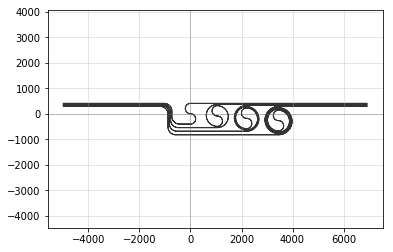

In [14]:
D = Device('SEMI')
D_b = Device('lb')
width = 1.5
xs = 50
ys = 90
for i in range(4):
    CEL = Device('CEL')
    foo = 1e3+i*xs
    SS = CEL << mn.semi_spiral(bend=430,shift=xs,width=width,layer=1, n=i).move((foo*i,-ys*i))
    EXR = CEL << mn.extend(port=SS.ports[2],length=6.5e3-(foo+xs)*i)
    EXL = CEL << mn.extend(port=SS.ports[1],length=(foo)*i)
    CN = pg.connector((-5e3,SS.ports[2].midpoint[1]),width,orientation=0)
    CEL << pr.route_manhattan(CN.ports[1],EXL.ports[2],bendType='circular',radius=300)    
    L = CEL.area()/width
    D_b << pg.text(text='WL%.2f'% L, position=((foo*i,100-ys*i)))
    D << CEL
#       D.area()/width

D_out = pg.outline(D,distance=10)
D_out << D_b

D_out.flatten().write_gds('templates/semicircle-spiral_align.gds')
qp(D)

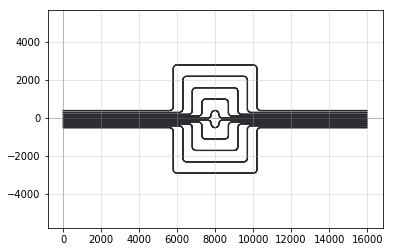

In [61]:
D = Device('array')

def swing(length=1.3e3, height=100, bend=200):
    D = Device('swing')
    subL = length - height - 2*bend
    assert subL > 100
    WG1 = D << mn.waveguide(length=subL,width=1.5)
    BD1 = D << pg.turn(port=WG1.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG2 = D << mn.extend(port=BD1.ports[2],length=height)
    BD2 = D << pg.turn(port=WG2.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG3 = D << mn.extend(port=BD2.ports[2],length=2*height)
    BD3 = D << pg.turn(port=WG3.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG4 = D << mn.extend(port=BD3.ports[2],length=height)
    BD4 = D << pg.turn(port=WG4.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG5 = D << mn.extend(port=BD4.ports[2],length=subL)
    return D
# arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)

for i in range(5):
    D << swing(length=8e3,height=i*500).movey(i*100)
#     D << swing(height=200).movey(50)
#     D << swing(height=300).movey(100)

D << pg.copy(D).rotate(180).move((16e3,-100))
D_out = pg.outline(D.flatten(), distance=8, layer=1) 
# D.flatten().write_gds('swing_array.gds')
qp(D_out)
D_out.write_gds('180409_swing_posi_1500.gds')

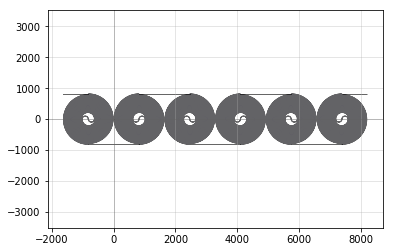

In [7]:
D = Device('archemedes_spiral')
D_b = Device('label')

width = 1.5
xs = 50
ys = 90
kw = {'width': 1.5,
     'layer': 1,
     'angle_resolution': 0.5}

AP = Device('unit_ap')
APC = AP << mn.archimedes(n=10,**kw,bent=100,distance=30)
APR = AP << mn.extend(port=APC.ports[2],length=APC.xmax+20)
APL = AP << mn.extend(port=APC.ports[1],length=APC.xmax+20)
AP.xmax=0
APsym = pg.copy(AP).reflect([0,0], [0,1])
APsym.xmin=0
AP << APsym 
D << AP

def add_asp():
    global AP
    APcopy = pg.copy(AP)
    APcopy.xmin=AP.xmax
    AP = APcopy
    return D << APcopy

add_asp()
add_asp()
D_out = pg.outline(D,distance=16,layer=31)
D_out << D_b

D_out.flatten().write_gds('templates/archemedes_spiral.gds')
qp(D)

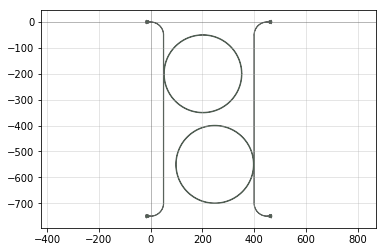

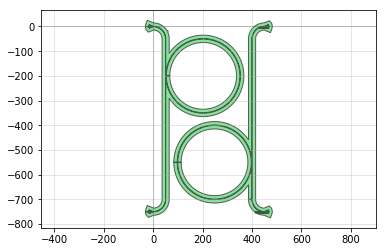

In [2]:
D = Device('PG')

args = {'width': 1}
pitch = 250*3

WG = Device('WG')
bt1 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(90).move((0,-50))
WG << mn.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args)

bt2 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(180).move((0,50-pitch))
WG << mn.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args).movey(-pitch)

bus = WG << pr.route_basic(port1=bt2.ports[1],port2=bt1.ports[2])

WG1 = D << pg.copy(WG).reflect([0,0], [0,1])
WG2 = D << pg.copy(WG).movex(450)

rg = pg.ring(150, 2).movey(-200)

RG1 = D << pg.copy(rg)
RG1.xmin = WG1.xmax + 0.4

RG2 = D << pg.copy(rg).movey(-350)
RG2.xmax = WG2.xmin - 0.5


D_out = pg.outline(D, distance = 14)


qp(D)
qp(D_out)
# D_out.write_gds('arc_gc.gds')
# D.xmax-D.xmin
# D.write_gds('arc_graitng.gds')

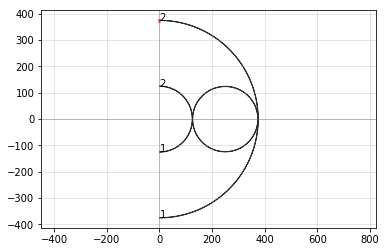

In [5]:
D = Device('AD-MRR')

w = 1
pitch = 250
gap = 0

ra1 = pitch/2
ra2 = 3*pitch/2
r = (ra2 - ra1)/2 - gap - w

args = {'width': w,
        'layer': 0}
arc1 = D << pg.arc(radius=ra1,start_angle=-90,theta=180,**args)
arc2 = D << pg.arc(radius=ra2,start_angle=-90,theta=180,**args)
rg = D << mn.ring(radius=r,**args,angle_resolution=1).move((r+ra1+gap+w,0))

# bus = D << mn.waveguide(length=100,**args)

# D << pg.deepcopy(bus) 
qp(D)

D.write_gds('templates/AD-MRR.gds')

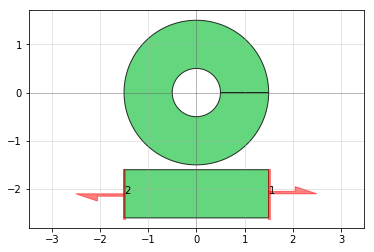

In [16]:
def ALLPASS(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS = D << mn.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D

def FOURPORT(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS1 = D << mn.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    BUS2 = D << mn.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS1.ymax = RG.ymin - gap
    BUS2.ymin = RG.ymax + gap    
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    D.add_port(name = 3, midpoint = [D.xmax,D.ymax-width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 4, midpoint = [D.xmin,D.ymax-width_bus/2], width = width_bus, orientation = 180)
    return D

# def FOURPORT()

D = Device('view')
D << ALLPASS(radius=1)
qp(D)
# D.write_gds('view.gds')

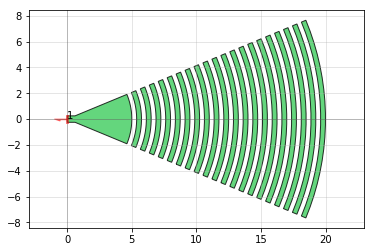

In [3]:
D = Device('PG')

D << pg.arc(radius=10,start_angle=0,theta=90,width=2)
D << mn.arc_grating()
qp(D)
D.write_gds('arc_gc.gds')
# D.write_gds('arc_graitng.gds')

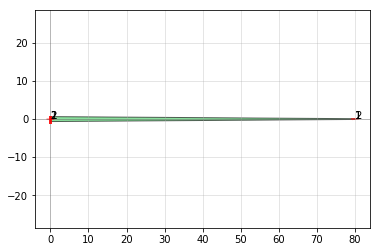

In [23]:
D = Device('mode_converter')

length = 80
CT1 = D << pg.connector(width=0.2).movex(length)
CT2 = D << pg.connector(width=1.3)
TP = D << pr.route_basic(port1=CT1.ports[1],port2=CT2.ports[2])

qp(D)
# D.write_gds('inverse_taper.gds')

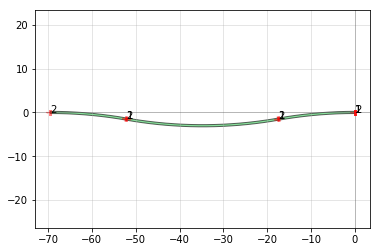

In [47]:
D = Device('bus')

wg1 = D << pg.connector(width=0.5)
arc1 = D << pg.turn(wg1.ports[2],angle=10,radius=100,angle_resolution=1)
arc2 = D << pg.turn(arc1.ports[2],angle=-20,radius=100,angle_resolution=1)
arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)
# wg2 = D << waveguide(0.5,20)
qp(D)
# D.write_gds('view.gds')

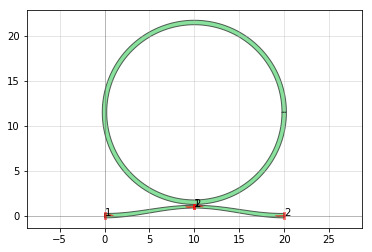

'view.gds'

In [34]:
D = Device('bus')

# gt1 = D << mn.arc_grating().rotate(180)
a1 = pg.connector((0,0),0.5)
a2 = pg.connector((10,1),0.3)
a3 = pg.connector((20,0),0.5)

w1 = D << pr.route_basic(port1=a1.ports[2],port2=a2.ports[1])
w2 = D << pr.route_basic(port1=a2.ports[2],port2=a3.ports[1])
rg = D << pg.ring(radius=10, width=0.5).move((10,12))

rg.ymin = w1.ymax + 0.1
qp(D)
D.write_gds('view.gds')